In [2]:
# ======================================
# Cell 1: Install Dependencies 
# ======================================

import warnings
import os
os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')

# Installing packages 
!pip install -q --no-warn-conflicts "protobuf==3.20.1" transformers datasets accelerate sentence-transformers scikit-learn openpyxl rdkit-pypi optuna

print("Dependencies installed successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 35.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━

In [3]:
# ======================================
# Cell 2: Import Libraries
# ======================================
"""
Import all necessary libraries for data processing, modeling, and visualization.
Set random seeds for reproducibility across numpy, torch, and CUDA operations.
"""
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import optuna
from optuna.trial import TrialState
import pickle 
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"All libraries imported successfully!")
print(f"Using device: {device.upper()}")

2025-11-11 17:33:19.841343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762882400.040616      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762882400.093937      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully!
Using device: CPU


In [4]:
# ======================================
# Cell 3: Load Dataset
# ======================================
"""
Loading the Dreher-Doyle dataset from Excel file.
"""
"Change path as required"
file_path = "/kaggle/input/dataset-che/dreher_doyle.xlsx"
xls = pd.ExcelFile(file_path)
first_sheet = xls.sheet_names[0]
data = pd.read_excel(xls, first_sheet)

print(f"Dataset shape: {data.shape}")
print(f"\nColumn names: {list(data.columns)}")

# yield statistics
print(f"\nTarget variable (Output) statistics:")
display(data['Output'].describe())
display(data.head())

Dataset shape: (3955, 5)

Column names: ['Ligand', 'Additive', 'Base', 'Aryl halide', 'Output']

Target variable (Output) statistics:


count    3955.000000
mean       33.085259
std        27.291205
min         0.000000
25%         7.877560
50%        28.761729
75%        53.278687
max        99.999990
Name: Output, dtype: float64

,Ligand,Additive,Base,Aryl halide,Output
0,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,CC1=CC(C)=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,ClC1=NC=CC=C1,70.410458
1,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,O=C(OC)C1=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,BrC1=NC=CC=C1,11.064457
2,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)...,O=C(OC)C1=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,IC1=CC=C(CC)C=C1,10.223550
3,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)...,CCOC(C1=CON=C1)=O,CN1CCCN2C1=NCCC2,ClC1=CC=C(C(F)(F)F)C=C1,20.083383
4,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,CC1=CC(C)=NO1,CN1CCCN2C1=NCCC2,ClC1=CC=C(OC)C=C1,0.492663


In [5]:
# ======================================
# Cell 4: Data Cleaning and Preprocessing
# ======================================
"""
Cleaning the dataset by removing missing values, invalid entries, and duplicates.
Filter yields to a valid range (0-100%).
"""
initial_shape = data.shape[0]
print(f"Initial dataset size: {initial_shape} rows")

# Defining SMILES component columns
smiles_cols = ["Ligand", "Additive", "Base", "Aryl halide"]

# Removing the rows with missing SMILES or yield values
data_clean = data.dropna(subset=smiles_cols + ["Output"]).copy()
print(f"After removing missing values: {data_clean.shape[0]} rows")

# Ensuring that the output is numeric and handling potential string errors
data_clean["Output"] = pd.to_numeric(data_clean["Output"], errors='coerce')
data_clean = data_clean.dropna(subset=["Output"])
print(f"After ensuring numeric outputs: {data_clean.shape[0]} rows")

# Removing duplicates based on SMILES components and yield
data_clean = data_clean.drop_duplicates(subset=smiles_cols + ["Output"])
print(f"After removing duplicates: {data_clean.shape[0]} rows")

# Filtering the yields to valid range (0-100%)
data_clean = data_clean[(data_clean["Output"] >= 0) & (data_clean["Output"] <= 100)]
print(f"After filtering yield range (0-100): {data_clean.shape[0]} rows")

print(f"\nData cleaning complete! Final shape: {data_clean.shape}")
print(f"Total rows removed: {initial_shape - data_clean.shape[0]} ({((initial_shape - data_clean.shape[0])/initial_shape*100):.2f}%)")

Initial dataset size: 3955 rows
After removing missing values: 3955 rows
After ensuring numeric outputs: 3955 rows
After removing duplicates: 3955 rows
After filtering yield range (0-100): 3955 rows

Data cleaning complete! Final shape: (3955, 5)
Total rows removed: 0 (0.00%)


In [7]:
# ======================================
# Cell 5: Create Reaction SMILES
# ======================================
"""
Combine individual SMILES components into a single reaction SMILES string.
Format: Ligand.Additive.Base.Aryl_halide (period-separated standard notation).
Extracting the feature vectors (reaction_smiles) and target variable (yield).
"""
# Combine SMILES components with period separator
data_clean["reaction_smiles"] = (
    data_clean["Ligand"] + "." +
    data_clean["Additive"] + "." +
    data_clean["Base"] + "." +
    data_clean["Aryl halide"]
)

# Extract features and target variable
reaction_smiles = data_clean["reaction_smiles"].tolist()
y = data_clean["Output"].astype(float).values

print(f"Created {len(reaction_smiles)} combined reaction SMILES")
print(f"Example: {reaction_smiles[0]} -> Yield: {y[0]}%")

Created 3955 combined reaction SMILES
Example: CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC.CC1=CC(C)=NO1.CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC.ClC1=NC=CC=C1 -> Yield: 70.41045785%


In [8]:
# ======================================
# Cell 6: Generate ChemBERTa Embeddings
# ======================================
"""
Generate molecular embeddings using pre-trained ChemBERTa-77M-MTR model.
Embeddings capture molecular structure in a dense vector format.
"""
print("Loading ChemBERTa model...")
model_name = "DeepChem/ChemBERTa-77M-MTR"

# Load pre-trained sentence transformer model
chemberta = SentenceTransformer(model_name, device=device)
print(f"ChemBERTa model loaded on {device.upper()}")
print(f"\nGenerating embeddings for {len(reaction_smiles)} reactions...")

# Generate embeddings
embeddings = chemberta.encode(
    reaction_smiles,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\nEmbeddings generated successfully! Shape: {embeddings.shape}")
print(f"Quality check (NaNs): {np.isnan(embeddings).sum()}")

Loading ChemBERTa model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

ChemBERTa model loaded on CUDA

Generating embeddings for 3955 reactions...


Batches:   0%|          | 0/124 [00:00<?, ?it/s]


Embeddings generated successfully! Shape: (3955, 384)
Quality check (NaNs): 0


In [10]:
# ======================================
# Cell 7: Train/Test Split
# ======================================
"""
Split embeddings and targets into train/test sets
The test set (20%) remains completely unseen for final evaluation.
"""
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, random_state=SEED
)
print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")

Train shapes: (3164, 384), (3164,)
Test shapes: (791, 384), (791,)


In [12]:
# ======================================
# Cell 8: Standardization (Scaling)
# ======================================
"""
Fit StandardScaler ONLY on training data, then transform both training and test.
This prevents test data information (e.g., mean, std) from leaking into the training.
"""
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaler fitted on training set only. All features standardized.")

Scaler fitted on training set only. All features standardized.


In [12]:
# ======================================
# Cell 9: PCA Dimensionality Reduction
# ======================================
"""
Fit PCA ONLY on the scaled training set (retaining 95% variance).
This learns the principal components from the training data only.
Then, transform both train and test sets using the fitted PCA.
"""
pca = PCA(n_components=0.95, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA fitted. Train: {X_train_pca.shape}, Test: {X_test_pca.shape}")
print(f"Variance retained: {pca.explained_variance_ratio_.sum()*100:.2f}%")

PCA fitted. Train: (3164, 22), Test: (791, 22)
Variance retained: 95.07%


In [13]:
# ======================================
# Cell 10: Define Neural Network
# ======================================
"""
Define a Multi-Layer Perceptron (MLP) regressor.
Architecture includes configurable hidden layers with BatchNorm, ReLU, and Dropout.
"""
class MLPRegressor(nn.Module):
    """
    Args:
        input_dim (int): Number of input features (from PCA)
        hidden_dims (list): List of hidden layer dimensions
        dropout_rates (list): List of dropout rates for each hidden layer
    """
    def __init__(self, input_dim, hidden_dims, dropout_rates):
        super(MLPRegressor, self).__init__()
        layers = []
        prev_dim = input_dim

        # Construct hidden layers
        for hidden_dim, dropout in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

print("Neural network architecture defined (MLPRegressor).")

Neural network architecture defined (MLPRegressor).


In [14]:
# ======================================
# Cell 11: Hyperparameter Optimization (Optuna)
# ======================================
"""
Use Optuna to find the best hyperparameters.
The search is performed ONLY on the training data (X_train_pca).
A validation split is created from the training data within each trial.
The training loop now includes early stopping and pruning for efficiency.
"""

# Define training constants
EPOCHS_OPT = 150
PATIENCE_OPT = 20

def objective(trial):
    # Set seeds for reproducible trials
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    # Define hyperparameter search space
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    hidden_dim1 = trial.suggest_categorical("hidden_dim1", [256, 512, 768])
    hidden_dim2 = trial.suggest_categorical("hidden_dim2", [128, 256, 512])
    hidden_dim3 = trial.suggest_categorical("hidden_dim3", [64, 128, 256])
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.4)
    dropout3 = trial.suggest_float("dropout3", 0.0, 0.3)
    
    hidden_dims = [hidden_dim1, hidden_dim2, hidden_dim3]
    dropout_rates = [dropout1, dropout2, dropout3]

    # Create validation split from the training data (80/20)
    X_trn, X_val, y_trn, y_val = train_test_split(
        X_train_pca, y_train, test_size=0.2, random_state=SEED
    )
    
    # Create Tensors and DataLoaders
    X_trn_t = torch.tensor(X_trn, dtype=torch.float32)
    y_trn_t = torch.tensor(y_trn, dtype=torch.float32).view(-1, 1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    
    train_ds = TensorDataset(X_trn_t, y_trn_t)
    val_ds = TensorDataset(X_val_t, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

    # Initialize model and optimizer
    model = MLPRegressor(X_train_pca.shape[1], hidden_dims, dropout_rates).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_r2 = -np.inf
    patience_counter = 0

    # Training loop with early stopping
    for epoch in range(EPOCHS_OPT):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_preds.append(model(xb).cpu().numpy())
                val_targets.append(yb.cpu().numpy())
        
        val_r2 = r2_score(np.concatenate(val_targets), np.concatenate(val_preds))

        # Report to Optuna for pruning
        trial.report(val_r2, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early stopping logic
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE_OPT:
                break
                
    return best_val_r2

# Run the optimization study
print("Starting Optuna hyperparameter search...")
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="maximize", study_name="yield_prediction", sampler=sampler)
study.optimize(objective, n_trials=20, show_progress_bar=True) # n_trials=20 is low, consider 50-100 if time permits

best_params = study.best_trial.params
print("\nOptuna search complete.")
print(f"Best trial R2: {study.best_trial.value:.4f}")
print(f"Best hyperparameters: {best_params}")

[I 2025-11-09 09:47:25,234] A new study created in memory with name: yield_prediction


Starting Optuna hyperparameter search...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-09 09:47:49,723] Trial 0 finished with value: 0.8266540323590174 and parameters: {'lr': 0.0005611516415334506, 'batch_size': 32, 'weight_decay': 2.0513382630874486e-05, 'hidden_dim1': 768, 'hidden_dim2': 256, 'hidden_dim3': 64, 'dropout1': 0.17272998688284025, 'dropout2': 0.15502135295603015, 'dropout3': 0.09127267288786131}. Best is trial 0 with value: 0.8266540323590174.
[I 2025-11-09 09:48:00,208] Trial 1 finished with value: 0.8633521707416313 and parameters: {'lr': 0.0011207606211860567, 'batch_size': 128, 'weight_decay': 1.9010245319870364e-05, 'hidden_dim1': 768, 'hidden_dim2': 128, 'hidden_dim3': 256, 'dropout1': 0.16820964947491662, 'dropout2': 0.11951547789558387, 'dropout3': 0.28466566117599995}. Best is trial 1 with value: 0.8633521707416313.
[I 2025-11-09 09:48:23,952] Trial 2 finished with value: 0.8346653043148045 and parameters: {'lr': 0.00853618986286683, 'batch_size': 32, 'weight_decay': 0.000233596350262616, 'hidden_dim1': 768, 'hidden_dim2': 256, 'hidden_

In [15]:
# ======================================
# Cell 12: K-Fold Cross-Validation
# ======================================
"""
Apply 5-fold CV on the *entire* PCA-processed training set (X_train_pca).
This validates the stability and performance of the best hyperparameters.
The test set remains completely unseen.
"""
print("\nStarting K-Fold Cross-Validation Training...")

K_FOLDS = 5
EPOCHS = 150
PATIENCE = 20
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

fold_results = {
    'train_losses': [], 'val_losses': [], 'train_r2': [], 'val_r2': [],
    'final_r2': [], 'val_mae': [], 'val_rmse': [], 'predictions': [], 'actuals': []
}

# Use best params from Optuna
params = best_params
hidden_dims = [params['hidden_dim1'], params['hidden_dim2'], params['hidden_dim3']]
dropout_rates = [params['dropout1'], params['dropout2'], params['dropout3']]

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_pca)):
    print(f"\n{'='*70}\nFOLD {fold + 1}/{K_FOLDS}\n{'='*70}")
    
    # Split data for current fold
    X_trn_fold, X_val_fold = X_train_pca[train_idx], X_train_pca[val_idx]
    y_trn_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Tensors and DataLoaders
    X_trn_t = torch.tensor(X_trn_fold, dtype=torch.float32)
    y_trn_t = torch.tensor(y_trn_fold, dtype=torch.float32).view(-1, 1)
    X_val_t = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_t = torch.tensor(y_val_fold, dtype=torch.float32).view(-1, 1)
    
    train_dataset = TensorDataset(X_trn_t, y_trn_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    
    # Initialize model
    model = MLPRegressor(X_train_pca.shape[1], hidden_dims, dropout_rates).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    # Tracking variables
    train_losses_epoch, val_losses_epoch, train_r2_epoch, val_r2_epoch = [], [], [], []
    best_val_r2, patience_counter, best_model_state = -np.inf, 0, None
    
    print(f"Training Fold {fold+1}...")
    
    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss, train_preds_list, train_targets_list = 0.0, [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            train_preds_list.append(outputs.detach().cpu().numpy())
            train_targets_list.append(yb.cpu().numpy())
        
        # Validation phase
        model.eval()
        val_loss, val_preds_list, val_targets_list = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                val_preds_list.append(outputs.cpu().numpy())
                val_targets_list.append(yb.cpu().numpy())
        
        # Calculate metrics
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_r2 = r2_score(np.concatenate(train_targets_list), np.concatenate(train_preds_list))
        val_r2 = r2_score(np.concatenate(val_targets_list), np.concatenate(val_preds_list))
        
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses_epoch.append(train_loss)
        val_losses_epoch.append(val_loss)
        train_r2_epoch.append(train_r2)
        val_r2_epoch.append(val_r2)
        
        # Model checkpointing
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1:3d} | Train R2: {train_r2:.4f} | Val R2: {val_r2:.4f}")
        
        if patience_counter >= PATIENCE:
            print(f"  Early stopping triggered at epoch {epoch+1}")
            break
            
    # Load best model and evaluate
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        final_preds = model(X_val_t.to(device)).cpu().numpy().ravel()
    
    final_actuals = y_val_fold
    final_r2 = r2_score(final_actuals, final_preds)
    final_mae = mean_absolute_error(final_actuals, final_preds)
    final_rmse = np.sqrt(mean_squared_error(final_actuals, final_preds))
    
    # Store results
    fold_results['train_losses'].append(train_losses_epoch)
    fold_results['val_losses'].append(val_losses_epoch)
    fold_results['train_r2'].append(train_r2_epoch)
    fold_results['val_r2'].append(val_r2_epoch)
    fold_results['final_r2'].append(final_r2)
    fold_results['val_mae'].append(final_mae)
    fold_results['val_rmse'].append(final_rmse)
    fold_results['predictions'].append(final_preds)
    fold_results['actuals'].append(final_actuals)
    
    print(f"Fold {fold+1} Complete! Best Val R2: {final_r2:.4f}, MAE: {final_mae:.4f}")

print(f"\n{'='*70}\nK-Fold Cross-Validation Complete\n{'='*70}")

# Calculate aggregate metrics
avg_r2 = np.mean(fold_results['final_r2'])
std_r2 = np.std(fold_results['final_r2'])
print(f"Average CV R2 Score: {avg_r2:.4f} +/- {std_r2:.4f}")


Starting K-Fold Cross-Validation Training...

FOLD 1/5
Training Fold 1...
  Epoch  20 | Train R2: 0.8009 | Val R2: 0.7711
  Epoch  40 | Train R2: 0.8737 | Val R2: 0.8081
  Epoch  60 | Train R2: 0.8957 | Val R2: 0.8156
  Epoch  80 | Train R2: 0.9399 | Val R2: 0.8544
  Epoch 100 | Train R2: 0.9456 | Val R2: 0.8660
  Early stopping triggered at epoch 119
Fold 1 Complete! Best Val R2: 0.8633, MAE: 6.6011

FOLD 2/5
Training Fold 2...
  Epoch  20 | Train R2: 0.8062 | Val R2: 0.7525
  Epoch  40 | Train R2: 0.8696 | Val R2: 0.7696
  Epoch  60 | Train R2: 0.9063 | Val R2: 0.7915
  Epoch  80 | Train R2: 0.9337 | Val R2: 0.8139
  Epoch 100 | Train R2: 0.9390 | Val R2: 0.8197
  Epoch 120 | Train R2: 0.9416 | Val R2: 0.8261
  Epoch 140 | Train R2: 0.9512 | Val R2: 0.8275
Fold 2 Complete! Best Val R2: 0.8277, MAE: 7.1933

FOLD 3/5
Training Fold 3...
  Epoch  20 | Train R2: 0.7903 | Val R2: 0.7012
  Epoch  40 | Train R2: 0.8778 | Val R2: 0.7791
  Epoch  60 | Train R2: 0.8973 | Val R2: 0.7837
  Epoch

Creating training visualization plots...


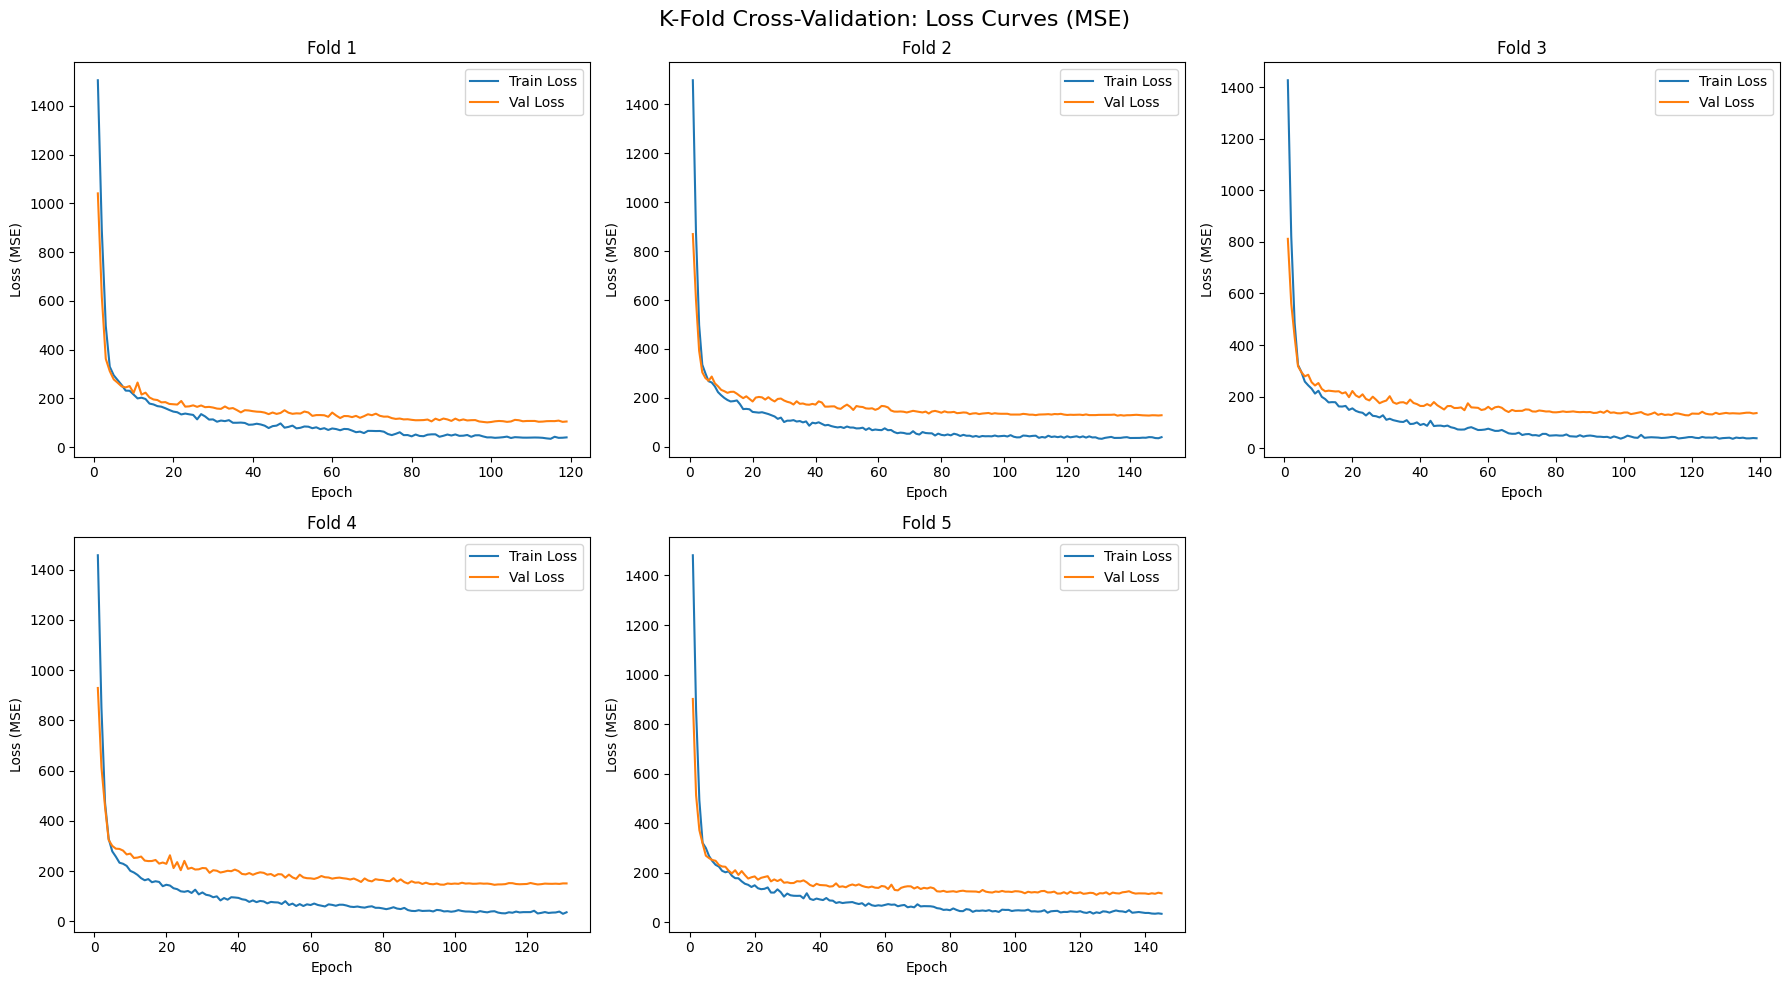

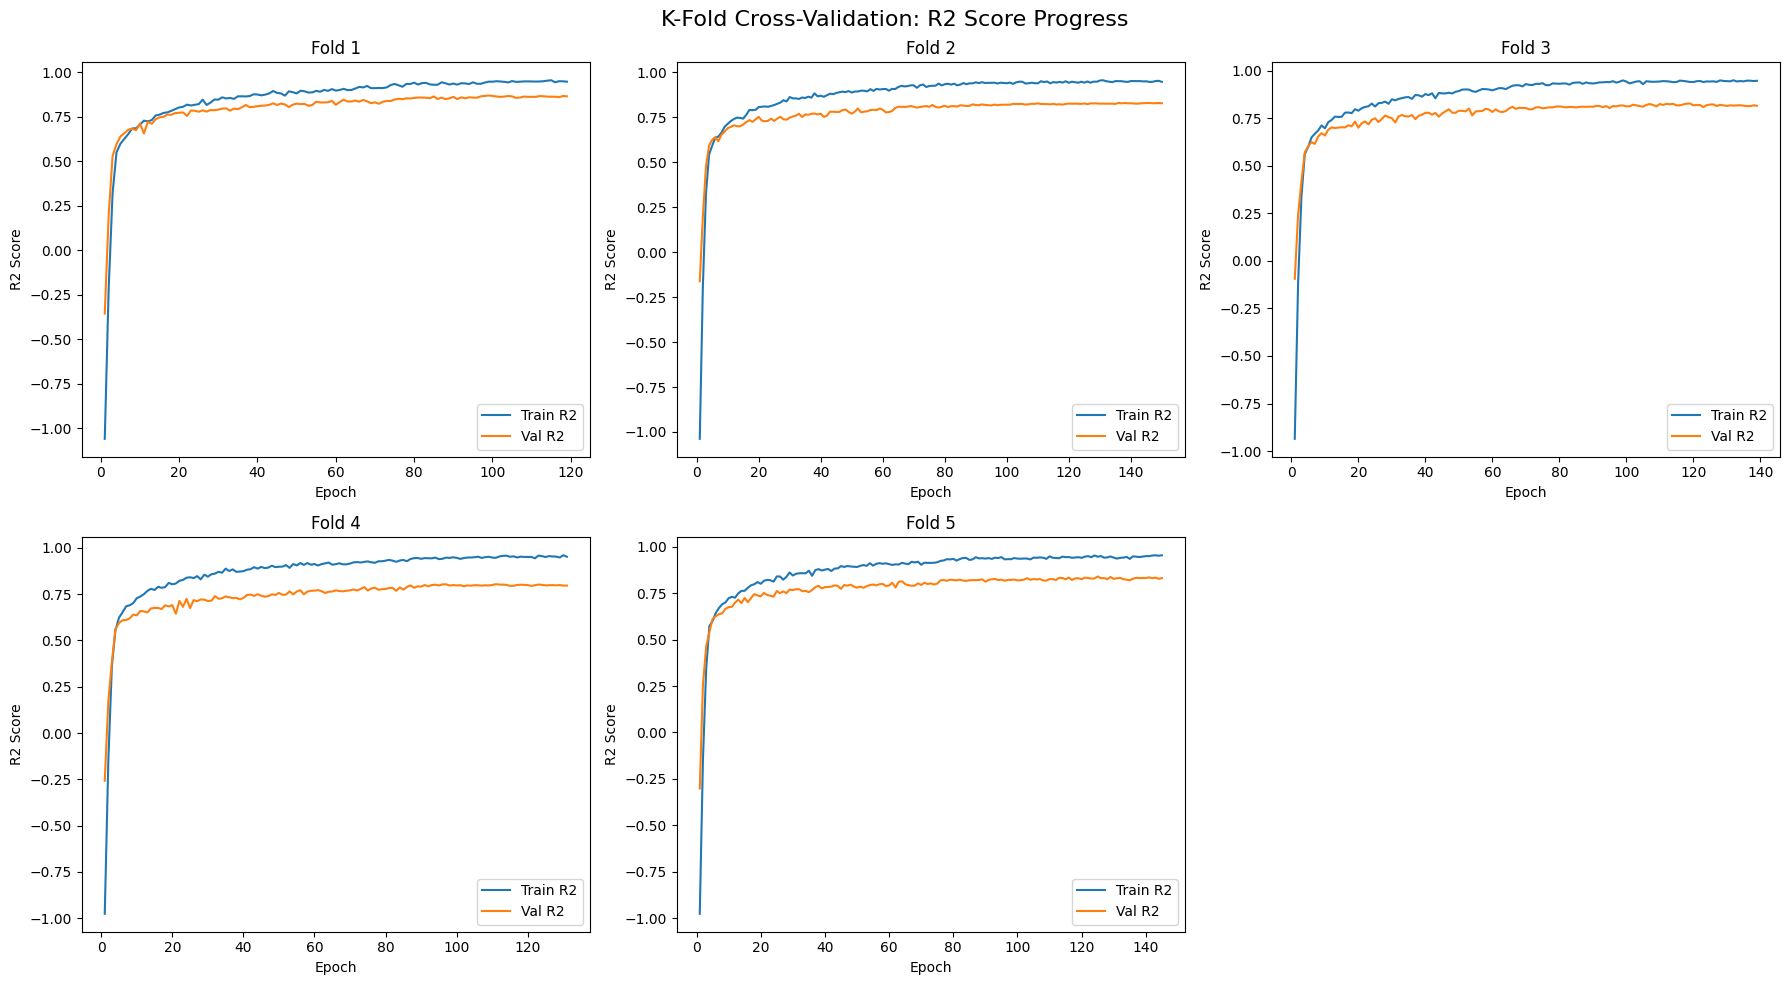

In [16]:
# ======================================
# Cell 13: Visualize CV Training
# ======================================
"""
Plot the training and validation loss/R2 curves for each of the K-Folds
to check for stability and overfitting.
"""
print("Creating training visualization plots...")

# Plot 1: Loss curves (MSE)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('K-Fold Cross-Validation: Loss Curves (MSE)', fontsize=16)
for fold in range(K_FOLDS):
    ax = axes[fold // 3, fold % 3]
    ax.plot(range(1, len(fold_results['train_losses'][fold]) + 1), fold_results['train_losses'][fold], label='Train Loss')
    ax.plot(range(1, len(fold_results['val_losses'][fold]) + 1), fold_results['val_losses'][fold], label='Val Loss')
    ax.set_title(f'Fold {fold+1}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
if K_FOLDS < 6: fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

# Plot 2: R2 score progression
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('K-Fold Cross-Validation: R2 Score Progress', fontsize=16)
for fold in range(K_FOLDS):
    ax = axes[fold // 3, fold % 3]
    ax.plot(range(1, len(fold_results['train_r2'][fold]) + 1), fold_results['train_r2'][fold], label='Train R2')
    ax.plot(range(1, len(fold_results['val_r2'][fold]) + 1), fold_results['val_r2'][fold], label='Val R2')
    ax.set_title(f'Fold {fold+1}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('R2 Score')
    ax.legend()
if K_FOLDS < 6: fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

In [17]:
# ======================================
# Cell 14: CV Metrics and Analysis
# ======================================
"""
Calculate comprehensive regression metrics on all out-of-fold CV predictions.
This gives a robust estimate of model performance on the training data.
"""

print("Computing comprehensive CV evaluation metrics...")

# Combine predictions and actuals from all folds
all_predictions = np.concatenate(fold_results['predictions'])
all_actuals = np.concatenate(fold_results['actuals'])

def symmetric_mape(y_true, y_pred):
    """ Calculate Symmetric Mean Absolute Percentage Error (sMAPE). """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    smape = np.zeros_like(numerator)
    smape[mask] = (numerator[mask] / denominator[mask]) * 100
    return np.mean(smape)

# Calculate all evaluation metrics
cv_metrics = {
    'R2 Score': r2_score(all_actuals, all_predictions),
    'MSE': mean_squared_error(all_actuals, all_predictions),
    'RMSE': np.sqrt(mean_squared_error(all_actuals, all_predictions)),
    'MAE': mean_absolute_error(all_actuals, all_predictions),
    'sMAPE': symmetric_mape(all_actuals, all_predictions),
    'Explained Variance': explained_variance_score(all_actuals, all_predictions)
}

print("="*70)
print("COMPREHENSIVE CV EVALUATION METRICS (on OOF predictions)")
print("="*70)
for metric_name, value in cv_metrics.items():
    print(f"{metric_name:<25} {value:.4f}")
print("="*70)

Computing comprehensive CV evaluation metrics...
COMPREHENSIVE CV EVALUATION METRICS (on OOF predictions)
R2 Score                  0.8272
MSE                       127.5110
RMSE                      11.2921
MAE                       7.1451
sMAPE                     44.9389
Explained Variance        0.8278



Creating CV prediction analysis visualizations...


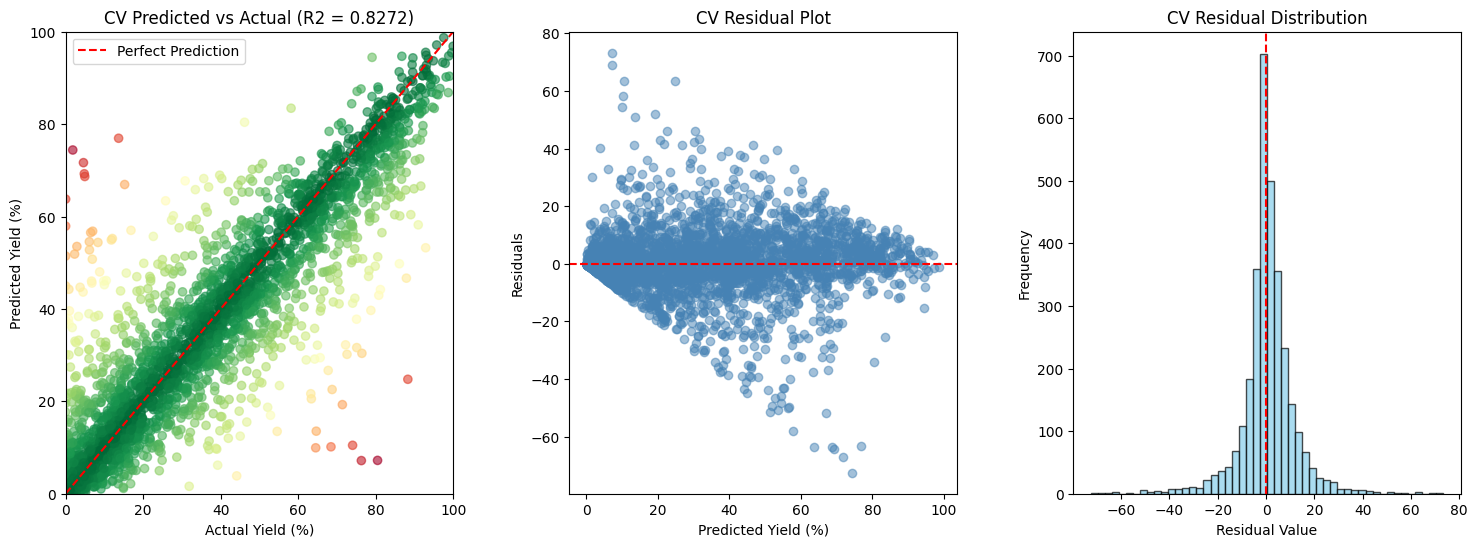

In [18]:
# ======================================
# Cell 15: CV Prediction Visualization
# ======================================
"""
Create analysis plots for the out-of-fold (OOF) CV predictions.
Includes: predicted vs actual scatter, residual plots, and error distributions.
"""
print("\nCreating CV prediction analysis visualizations...")

fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3, wspace=0.3)
residuals = all_actuals - all_predictions

# Subplot 1: Predicted vs Actual
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(all_actuals, all_predictions, c=np.abs(residuals), cmap='RdYlGn_r', alpha=0.6)
ax1.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
ax1.set_xlabel('Actual Yield (%)')
ax1.set_ylabel('Predicted Yield (%)')
ax1.set_title(f'CV Predicted vs Actual (R2 = {cv_metrics["R2 Score"]:.4f})')
ax1.legend()
ax1.set_xlim([0, 100])
ax1.set_ylim([0, 100])

# Subplot 2: Residual plot
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(all_predictions, residuals, alpha=0.5, c='steelblue')
ax2.axhline(y=0, color='red', linestyle='--')
ax2.set_xlabel('Predicted Yield (%)')
ax2.set_ylabel('Residuals')
ax2.set_title('CV Residual Plot')

# Subplot 3: Residual distribution
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--')
ax3.set_xlabel('Residual Value')
ax3.set_ylabel('Frequency')
ax3.set_title('CV Residual Distribution')

plt.tight_layout()
plt.show()

In [19]:
# ======================================
# Cell 16: CV Summary Table
# ======================================
"""
Creating summary table of performance metrics for each fold.
"""
print("\nCreating K-Fold performance summary table...")

summary_data = {
    'Fold': [f'Fold {i+1}' for i in range(K_FOLDS)] + ['Average', 'Std Dev'],
    'R2 Score': fold_results['final_r2'] + [avg_r2, std_r2],
    'MAE': fold_results['val_mae'] + [np.mean(fold_results['val_mae']), np.std(fold_results['val_mae'])],
    'RMSE': fold_results['val_rmse'] + [np.mean(fold_results['val_rmse']), np.std(fold_results['val_rmse'])]
}
summary_df = pd.DataFrame(summary_data)

print("="*70)
print("K-FOLD CROSS-VALIDATION SUMMARY")
print("="*70)
display(summary_df.round(4))


Creating K-Fold performance summary table...
K-FOLD CROSS-VALIDATION SUMMARY


,Fold,R2 Score,MAE,RMSE
0,Fold 1,0.8633,6.6011,10.2406
1,Fold 2,0.8277,7.1933,11.3559
2,Fold 3,0.8163,7.4403,11.6741
3,Fold 4,0.7958,7.5279,12.2818
4,Fold 5,0.8316,6.9625,10.7973
5,Average,0.8269,7.1450,11.2700
6,Std Dev,0.0220,0.3362,0.7039


In [20]:
# ======================================
# Cell 17: Train Final Model
# ======================================
"""
Train the final model on the full training set (X_train_pca) using
the best hyperparameters.
We create a new 80/20 split (train_final/val_final) from the full
training set to monitor for early stopping. This prevents overfitting.
"""
print("\nTraining final model on all training data...")

# Use best params from Optuna
params = best_params
hidden_dims = [params['hidden_dim1'], params['hidden_dim2'], params['hidden_dim3']]
dropout_rates = [params['dropout1'], params['dropout2'], params['dropout3']]

# Create a new split from the FULL training set for early stopping
X_trn_final, X_val_final, y_trn_final, y_val_final = train_test_split(
    X_train_pca, y_train, test_size=0.2, random_state=SEED
)

# Create Tensors and DataLoaders
X_trn_t = torch.tensor(X_trn_final, dtype=torch.float32)
y_trn_t = torch.tensor(y_trn_final, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val_final, dtype=torch.float32)
y_val_t = torch.tensor(y_val_final, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_trn_t, y_trn_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Initialize final model
final_model = MLPRegressor(X_train_pca.shape[1], hidden_dims, dropout_rates).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(final_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

best_val_r2, patience_counter, best_model_state = -np.inf, 0, None

print(f"Training final model for up to {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    final_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()

    # Validation phase
    final_model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_preds.append(final_model(xb).cpu().numpy())
            val_targets.append(yb.cpu().numpy())
    
    val_r2 = r2_score(np.concatenate(val_targets), np.concatenate(val_preds))

    # Checkpointing
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        patience_counter = 0
        best_model_state = final_model.state_dict().copy()
    else:
        patience_counter += 1

    if (epoch + 1) % 20 == 0:
        print(f"  Epoch {epoch+1:3d} | Final Model Val R2: {val_r2:.4f}")

    if patience_counter >= PATIENCE:
        print(f"  Early stopping triggered at epoch {epoch+1}")
        break

# Load the best performing model state
final_model.load_state_dict(best_model_state)
print(f"\nFinal model training complete. Best validation R2: {best_val_r2:.4f}")


Training final model on all training data...
Training final model for up to 150 epochs...
  Epoch  20 | Final Model Val R2: 0.7690
  Epoch  40 | Final Model Val R2: 0.8173
  Epoch  60 | Final Model Val R2: 0.8345
  Epoch  80 | Final Model Val R2: 0.8342
  Epoch 100 | Final Model Val R2: 0.8548
  Epoch 120 | Final Model Val R2: 0.8450
  Early stopping triggered at epoch 123

Final model training complete. Best validation R2: 0.8594


In [21]:
# ======================================
# Cell 18: Final Evaluation on Test Set and Save Artifacts
# ======================================
"""
Evaluate the FINAL trained model on the held-out test set (X_test_pca).
This provides an unbiased estimate of the model's generalization performance.
Also, save the final model and preprocessing objects.
"""
print("\nEvaluating final model on the unseen holdout test set...")
final_model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
    test_preds = final_model(X_test_t).cpu().numpy().ravel()

test_actuals = y_test

# Calculate test metrics
test_metrics = {
    'R2 Score': r2_score(test_actuals, test_preds),
    'MSE': mean_squared_error(test_actuals, test_preds),
    'RMSE': np.sqrt(mean_squared_error(test_actuals, test_preds)),
    'MAE': mean_absolute_error(test_actuals, test_preds),
    'sMAPE': symmetric_mape(test_actuals, test_preds), # Function from Cell 14
    'Explained Variance': explained_variance_score(test_actuals, test_preds),
    'Max Error': max_error(test_actuals, test_preds)
}

print("="*70)
print("FINAL HOLDOUT TEST SET METRICS")
print("="*70)
for k, v in test_metrics.items():
    print(f"{k:20}: {v:.4f}" if k != 'sMAPE' else f"{k:20}: {v:.2f}%")
print("="*70)


# --- Save Final Model and Preprocessing Objects ---
print("\nSaving final model and preprocessing objects...")

# 1. Save the final model state dictionary
torch.save(best_model_state, "/kaggle/working/final_model.pt")
print("Final model saved: /kaggle/working/final_model.pt")

# 2. Save the preprocessing objects
preprocessing_objects = {
    'scaler': scaler,
    'pca': pca,
    'chemberta_model_name': model_name,
    'best_params': best_params,
    'input_dim': X_train_pca.shape[1],
    'model_hidden_dims': hidden_dims,
    'model_dropout_rates': dropout_rates
}
with open('/kaggle/working/preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)
print("Preprocessing objects saved: /kaggle/working/preprocessing_objects.pkl")

# 3. Save test predictions
test_predictions_df = pd.DataFrame({
    'Actual_Yield': test_actuals,
    'Predicted_Yield': test_preds,
    'Residual': test_actuals - test_preds
})
test_predictions_df.to_csv('/kaggle/working/test_set_predictions.csv', index=False)
print("Test set predictions saved: /kaggle/working/test_set_predictions.csv")


Evaluating final model on the unseen holdout test set...
FINAL HOLDOUT TEST SET METRICS
R2 Score            : 0.8190
MSE                 : 139.4759
RMSE                : 11.8100
MAE                 : 7.5544
sMAPE               : 46.74%
Explained Variance  : 0.8235
Max Error           : 61.7898

Saving final model and preprocessing objects...
Final model saved: /kaggle/working/final_model.pt
Preprocessing objects saved: /kaggle/working/preprocessing_objects.pkl
Test set predictions saved: /kaggle/working/test_set_predictions.csv


In [22]:
# ======================================
# Cell 19: Inference Function
# ======================================
"""
Define a prediction function that encapsulates the entire pipeline
for new, unseen data. It loads the saved model and preprocessing objects.
"""

def load_prediction_pipeline(model_path, objects_path):
    """Loads the saved model and preprocessing objects."""
    # Load preprocessing objects
    with open(objects_path, 'rb') as f:
        objects = pickle.load(f)
    
    scaler = objects['scaler']
    pca = objects['pca']
    
    # Load the ChemBERTa model
    chemberta = SentenceTransformer(objects['chemberta_model_name'], device=device)
    
    # Initialize model architecture
    model = MLPRegressor(
        input_dim=objects['input_dim'],
        hidden_dims=objects['model_hidden_dims'],
        dropout_rates=objects['model_dropout_rates']
    ).to(device)
    
    # Load the saved model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    print("Prediction pipeline loaded successfully.")
    return model, chemberta, scaler, pca

def predict_reaction_yield(ligand, additive, base, aryl_halide, pipeline):
    """
    Predicts yield for a single reaction using the loaded pipeline.
    
    Args:
        pipeline (tuple): (model, chemberta, scaler, pca)
    """
    model, chemberta, scaler, pca = pipeline
    
    # 1. Create reaction SMILES
    reaction_smiles = f"{ligand}.{additive}.{base}.{aryl_halide}"
    
    # 2. Generate embedding
    embedding = chemberta.encode([reaction_smiles], convert_to_numpy=True)
    
    # 3. Scale embedding
    embedding_scaled = scaler.transform(embedding)
    
    # 4. Apply PCA
    embedding_pca = pca.transform(embedding_scaled)
    
    # 5. Predict
    with torch.no_grad():
        X_tensor = torch.tensor(embedding_pca, dtype=torch.float32).to(device)
        prediction = model(X_tensor).cpu().numpy()[0, 0]
        
    return float(prediction)

# --- Example Usage ---
print("\nSetting up prediction function...")
try:
    # Load the pipeline
    model_pipeline = load_prediction_pipeline(
        model_path="/kaggle/working/final_model.pt",
        objects_path="/kaggle/working/preprocessing_objects.pkl"
    )
    
    # Example prediction (using a known row from the dataset for demo)
    # Note: In a real scenario, you'd use new, unseen SMILES strings.
    example_row = data_clean.iloc[0]
    
    pred_yield = predict_reaction_yield(
        ligand=example_row["Ligand"],
        additive=example_row["Additive"],
        base=example_row["Base"],
        aryl_halide=example_row["Aryl halide"],
        pipeline=model_pipeline
    )
    print(f"\nExample Prediction:")
    print(f"  SMILES: {example_row['reaction_smiles']}")
    print(f"  Actual Yield: {example_row['Output']}%")
    print(f"  Predicted Yield: {pred_yield:.2f}%")
    
except FileNotFoundError:
    print("\nCould not load saved models for prediction function demo.")
    print("Please ensure Cell 18 has been run successfully.")
except Exception as e:
    print(f"\nError in prediction function setup: {e}")

print("\n--- Workflow Complete ---")


Setting up prediction function...


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction pipeline loaded successfully.

Example Prediction:
  SMILES: CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC.CC1=CC(C)=NO1.CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC.ClC1=NC=CC=C1
  Actual Yield: 70.41045785%
  Predicted Yield: 78.12%

--- Workflow Complete ---
